# **NBA Player Performance vs. Salary (2022–2023)** *DIVE Analysis from the lens of 'Operations'*

#### **Role:** Operational Excellence Analyst  
####**Audience:** Team owners, GMs, coaches, and NBA enthusiasts  
####**Goal:** Align **minutes** and **salary** with **on-court value**—so every dollar and every minute works.

### **Business Challenge**
In a salary-capped league, every dollar and every minute must work. Teams often overplay underperformers, under-use rising contributors, and tie up cap space in deals that no longer match on-court value. The real challenge isn’t just spotting mismatches—it’s turning them into rotation changes and contract decisions that can change a season’s trajectory.

### **Method (at a glance)**
We evaluate value with a blended **Performance Score** that balances efficiency and output:  
**Performance Score (PS) = PER + PTS + AST + REB + BLK + (MP ÷ 5)**  
We pair this with **PER**, **minutes per game (MP)**, and **points per game (PTS)** to compare **performance rank vs salary rank** and expose gaps.
Two simple signals guide decisions:
- **Rank Gap** = Salary_Rank − Performance_Rank (mismatch indicator)  
- **PS per Million Dollar** = PerformanceScore per $1M salary (bang‑for‑buck)

### **High‑Stakes Question**
**Which players are teams overpaying relative to their on‑court value, which players are delivering outsized performance for their cost (true “bang‑for‑the‑buck”), and how should minutes and contracts be realigned — now and over the next 12–24 months — to maximize output without raising payroll?**  

Specifically: (1) **Overpaid vs. Value**, (2) **Future Pillars** worth building around, (3) **Rotation Optimization** within positions, and (4) **Contract Strategy** for protection vs. review.

### **Why This Matters**
- **Cap Efficiency:** Mispriced roles restrict flexibility; fixing them unlocks options.  
- **Competitive Edge:** Elevating undervalued players boosts wins **without** new spending.  
- **Talent Retention:** Spot future pillars early and extend before price spikes.  
- **Fan Impact:** A sharper rotation sustains excitement, ticket sales, and relevance.

### **Assumptions & Constraints**
- Performance Score (PS) balances **efficiency** (PER) and **production** (PTS/AST/REB/BLK) with a scaled availability term (MP ÷ 5).  
- Position buckets: `G` (guards), `W` (wings), `F` (forwards), `C` (centers) to keep rotation changes realistic.  
- Rotation eligibility filter: `G ≥ 30` and `MP ≥ 18` minutes per game.  
- Limits: injuries/scheme context are partially latent; we address realism later with **stress scenarios** (Validate).

In [1]:
# Environment Setup
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

np.random.seed(42)
pd.set_option('display.max_columns', 200)
pd.set_option('display.float_format', '{:,.3f}'.format)
print("Environment ready.")

Environment ready.


## **Data Access**
**Option 1 (default): BigQuery** — `mgmt599-project-carlorama-lab2.nba_2023.player_perf`  
**Option 2: CSV Upload** — quick fallback.

In [2]:
# BigQuery (default)
USE_BIGQUERY = True  #@param {type:"boolean"}
PROJECT_ID = "mgmt599-project-carlorama-lab2"
DATASET_ID = "nba_2023"
TABLE_ID   = "player_perf"

df = None
if USE_BIGQUERY:
    try:
        from google.colab import auth  # type: ignore
        auth.authenticate_user()
    except Exception:
        pass
    from google.cloud import bigquery  # type: ignore
    client = bigquery.Client(project=PROJECT_ID)
    query = f"SELECT * FROM `mgmt599-project-carlorama-lab2.nba_2023.player_perf`"
    df = client.query(query).to_dataframe()
    print("Loaded from BigQuery:", df.shape)

Loaded from BigQuery: (896, 35)


In [3]:
# CSV Upload (fallback)
USE_UPLOAD = False  #@param {type:"boolean"}
if (not USE_BIGQUERY) and USE_UPLOAD:
    from google.colab import files  # type: ignore
    up = files.upload()
    csv_path = list(up.keys())[0]
    df = pd.read_csv(csv_path)
    print("Loaded from CSV:", df.shape)

if df is None:
    try:
        df = pd.read_csv("cleaned_pergame_and_advance_2023_w_salaries.csv")
        print("Loaded local CSV:", df.shape)
    except Exception:
        print("No data loaded yet. Enable BigQuery or CSV Upload.")

## **Feature Engineering**
We derive simple, decision‑ready features that make minutes and dollars comparable across roles.

In [4]:
# Normalize column names if needed
rename_map = {
    "Player":"player","Team":"team","Pos":"pos","G":"g","MP":"mp","PER":"per",
    "PTS":"pts","AST":"ast","TRB":"trb","BLK":"blk","Adjusted Salary":"adjusted_salary"
}
for k,v in rename_map.items():
    if k in df.columns and v not in df.columns:
        df.rename(columns={k:v}, inplace=True)

# Required fields
req = ["player","team","pos","g","mp","per","pts","ast","trb","blk","adjusted_salary"]
missing = [c for c in req if c not in df.columns]
if missing:
    raise ValueError(f"Missing required columns: {missing}")

# Salary to $M for readability
df["salary_m"] = df["adjusted_salary"]/1_000_000.0 if df["adjusted_salary"].median() > 1_000_000 else df["adjusted_salary"]

# Core features
df["PerformanceScore"] = df["per"] + df["pts"] + df["ast"] + df["trb"] + df["blk"] + (df["mp"]/5.0)
df["PS_per_M"]  = df["PerformanceScore"] / df["salary_m"].replace(0, np.nan)
df["Salary_Rank"] = df["salary_m"].rank(ascending=False, method="min")
df["Perf_Rank"]   = df["PerformanceScore"].rank(ascending=False, method="min")
df["Value_Gap"]   = df["Salary_Rank"] - df["Perf_Rank"]  # positive = outperforming contract

# Shares & flags
df["Minutes_Share"] = df.groupby("team")["mp"].transform(lambda s: s / s.sum())
df["Value_Share"]   = df.groupby("team")["PerformanceScore"].transform(lambda s: s / s.sum())
df["Underutilized"] = (df["Value_Share"] - df["Minutes_Share"]) > 0.02

# Eligibility & position buckets
df["Eligible"] = (df["g"] >= 30) & (df["mp"] >= 18)
pos_map = {"PG":"G","SG":"G","G":"G","SF":"W","GF":"W","F":"F","PF":"F","C":"C","FC":"C","F-C":"C","C-F":"C"}
df["PosBucket"] = df["pos"].map(pos_map).fillna(df["pos"].astype(str).str[:1])

print("Feature engineering complete.")

Feature engineering complete.


# **DISCOVER — Where money and minutes meet production**
## **Narrative**
We start with a clear picture: how **salary dollars** and **court time** line up against **what players actually deliver**.
Think of this as a roster audit, not a verdict. The goal is to spot where expectations and reality diverge — the places where
we might be **overplaying cost** or **under‑playing value**. The visuals here are simple on purpose: they show who gives you the most
for each dollar, who’s earning their deal, and where salary gravity may be steering minutes more than performance.
  
**Gemini Prompt (Baseline)**  
“Analyze NBA player salary versus performance for the 2022–2023 season using the provided dataset. Calculate a Performance Score that combines PER, points, assists, rebounds, blocks, and scaled minutes played. Rank players by salary and by performance, then compare the two to identify who delivers the most value per dollar and who is overpaid for their output. Create clear visuals that highlight these patterns for both players and teams.”

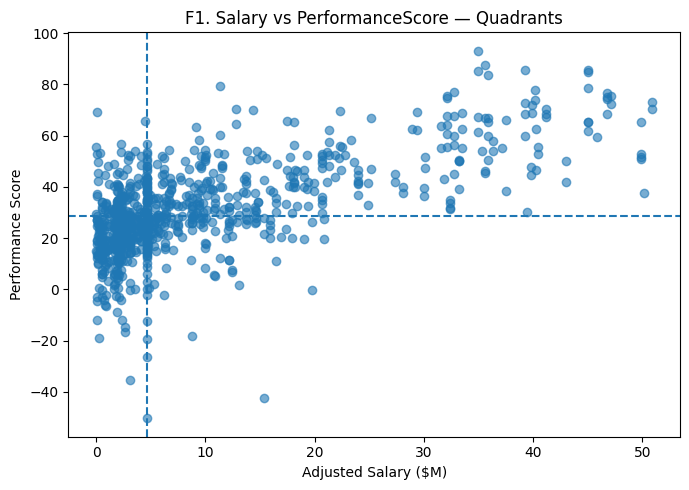

In [5]:
plt.figure(figsize=(7,5))
x = df["salary_m"]; y = df["PerformanceScore"]
plt.scatter(x, y, alpha=0.6)
plt.axvline(x.median(), linestyle="--")
plt.axhline(y.median(), linestyle="--")
plt.xlabel("Adjusted Salary ($M)"); plt.ylabel("Performance Score")
plt.title("F1. Salary vs PerformanceScore — Quadrants")
plt.tight_layout(); plt.show()

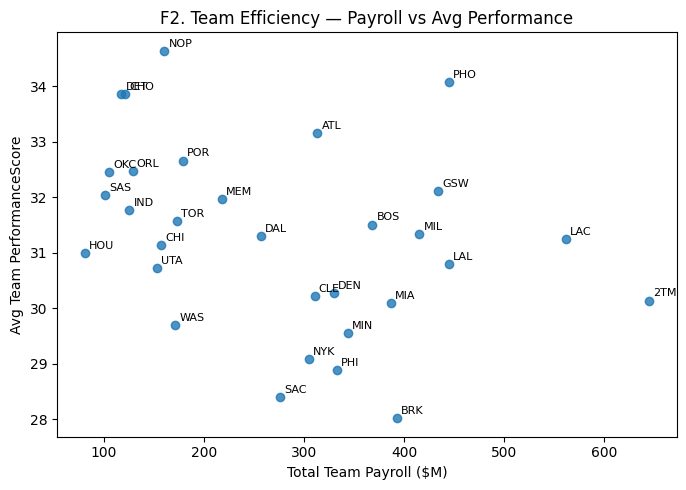

In [6]:
team_eff = (df.groupby("team")
              .agg(Total_Payroll_M=("salary_m","sum"),
                   Avg_PER=("per","mean"),
                   Avg_PS=("PerformanceScore","mean"),
                   Players=("player","nunique"))
              .reset_index()
              .sort_values("Avg_PS", ascending=False))

plt.figure(figsize=(7,5))
plt.scatter(team_eff["Total_Payroll_M"], team_eff["Avg_PS"], alpha=0.8)
for _, r in team_eff.iterrows():
    plt.annotate(r["team"], (r["Total_Payroll_M"], r["Avg_PS"]), fontsize=8, xytext=(3,3), textcoords="offset points")
plt.xlabel("Total Team Payroll ($M)"); plt.ylabel("Avg Team PerformanceScore")
plt.title("F2. Team Efficiency — Payroll vs Avg Performance")
plt.tight_layout(); plt.show()

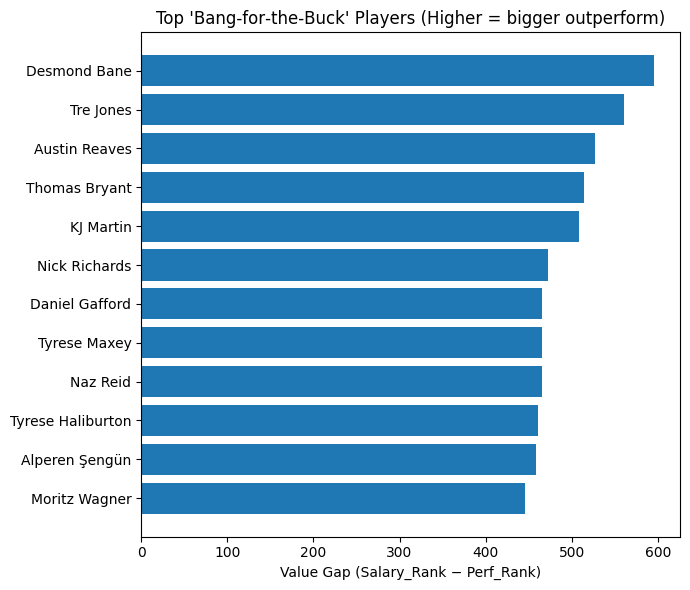

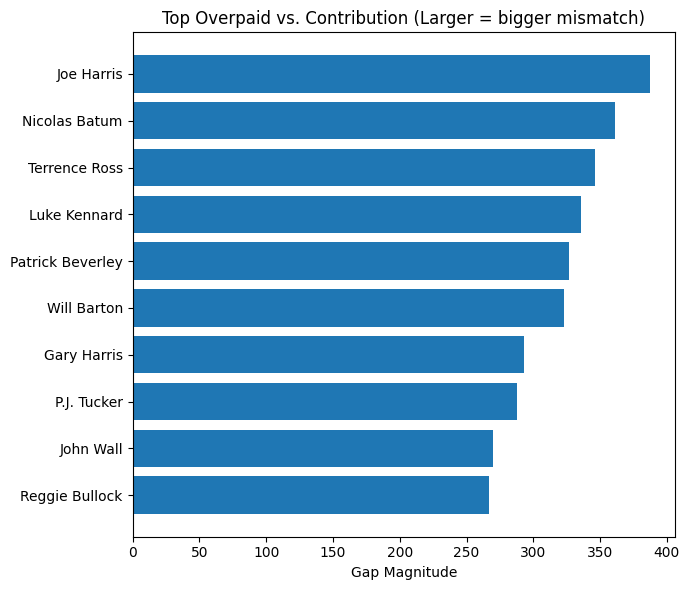

In [7]:
# Shortlists (eligible rotation players)
underval = df[df["Eligible"]].sort_values(["Value_Gap","PS_per_M"], ascending=[False, False]).head(15)
overval  = df[df["Eligible"]].sort_values(["Value_Gap"], ascending=[True]).head(15)

# Undervalued
uv = underval.sort_values("Value_Gap", ascending=False).head(12)
plt.figure(figsize=(7,6))
plt.barh(uv["player"], uv["Value_Gap"])
plt.gca().invert_yaxis()
plt.xlabel("Value Gap (Salary_Rank − Perf_Rank)")
plt.title("Top 'Bang‑for‑the‑Buck' Players (Higher = bigger outperform)")
plt.tight_layout(); plt.show()

# Overvalued
ov = overval.sort_values("Value_Gap", ascending=True).head(12)
plt.figure(figsize=(7,6))
plt.barh(ov["player"], -ov["Value_Gap"])
plt.gca().invert_yaxis()
plt.xlabel("Gap Magnitude")
plt.title("Top Overpaid vs. Contribution (Larger = bigger mismatch)")
plt.tight_layout(); plt.show()

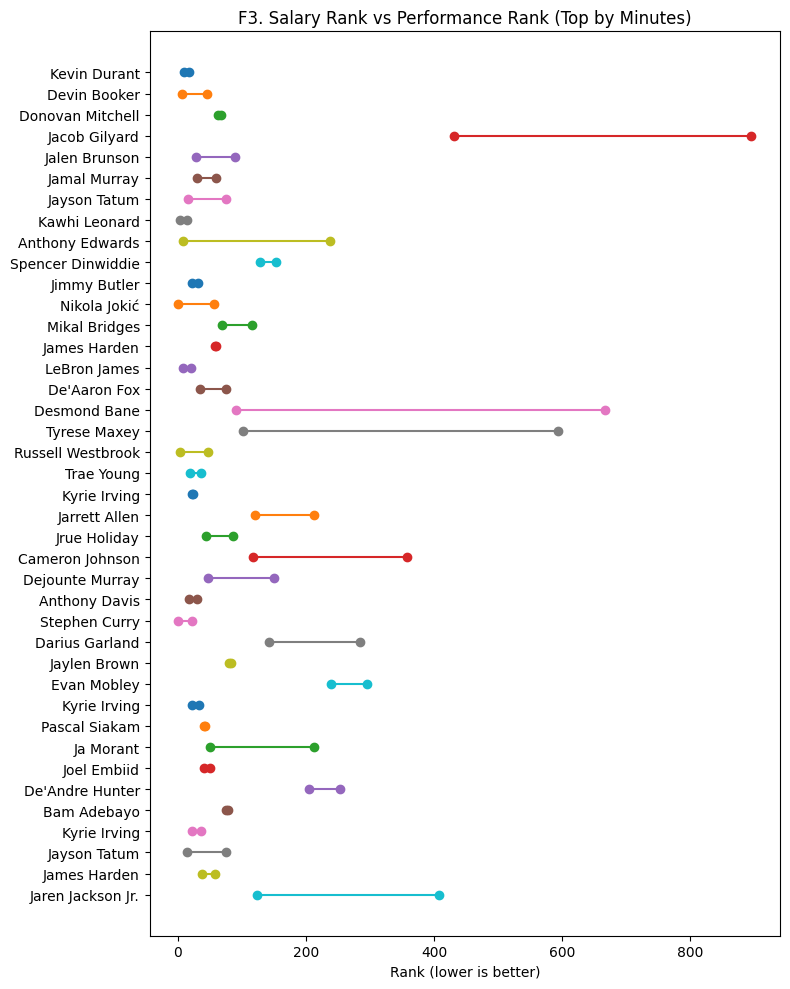

In [8]:
topN = 40
dumb = df.sort_values("mp", ascending=False).head(topN)[["player","Salary_Rank","Perf_Rank"]].copy()
plt.figure(figsize=(8,10))
ypos = np.arange(len(dumb))
for i,(sr,pr) in enumerate(zip(dumb["Salary_Rank"], dumb["Perf_Rank"])):
    plt.plot([sr, pr],[i,i], marker='o')
plt.yticks(ypos, dumb["player"]); plt.gca().invert_yaxis()
plt.xlabel("Rank (lower is better)"); plt.title("F3. Salary Rank vs Performance Rank (Top by Minutes)")
plt.tight_layout(); plt.show()

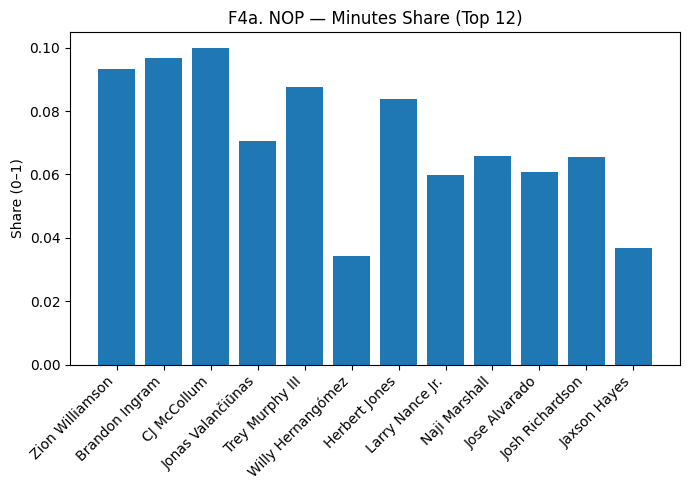

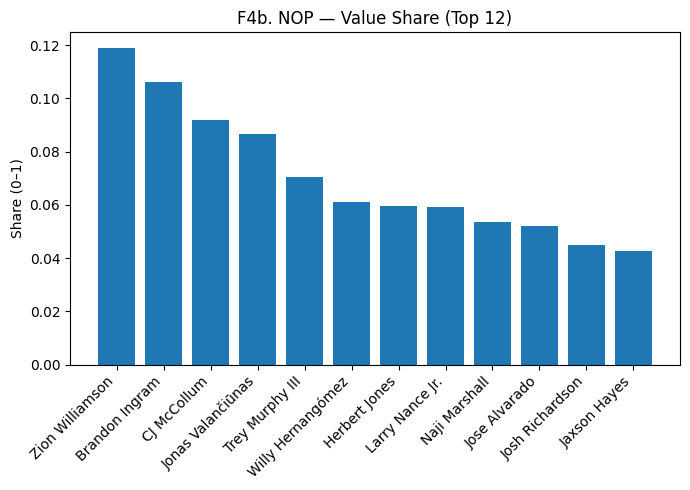

In [9]:
top_team = team_eff.iloc[0]["team"]
sample = df[df["team"]==top_team].sort_values("Value_Share", ascending=False).head(12)

plt.figure(figsize=(7,5))
plt.bar(sample["player"], sample["Minutes_Share"])
plt.xticks(rotation=45, ha="right"); plt.ylabel("Share (0–1)")
plt.title(f"F4a. {top_team} — Minutes Share (Top 12)")
plt.tight_layout(); plt.show()

plt.figure(figsize=(7,5))
plt.bar(sample["player"], sample["Value_Share"])
plt.xticks(rotation=45, ha="right"); plt.ylabel("Share (0–1)")
plt.title(f"F4b. {top_team} — Value Share (Top 12)")
plt.tight_layout(); plt.show()

In [10]:
from IPython.display import Markdown, display
med_salary = df["salary_m"].median(); med_perf = df["PerformanceScore"].median()
elite = int(((df["salary_m"]<=med_salary) & (df["PerformanceScore"]>=med_perf)).sum())
overp = int(((df["salary_m"]>=med_salary) & (df["PerformanceScore"]<=med_perf)).sum())

uv_top = underval.head(1)[["player","team","Value_Gap"]].iloc[0].to_dict()
ov_top = overval.head(1)[["player","team","Value_Gap"]].iloc[0].to_dict()

text = (
    "## Overall Findings — Discover\n"
    f"The audit shows clear mismatches between **spend**, **minutes**, and **output**. We count **{elite}** players in the Elite Value quadrant "
    f"(low salary, high performance) and **{overp}** in the Overpaid quadrant. A simple rank‑gap view makes the story vivid: "
    f"**{uv_top['player']} ({uv_top['team']})** is a clear 'bang‑for‑the‑buck' case, while **{ov_top['player']} ({ov_top['team']})** "
    "signals a role worth rethinking. This sets the stage for targeted, not wholesale, change."
)
display(Markdown(text))

## Overall Findings — Discover
The audit shows clear mismatches between **spend**, **minutes**, and **output**. We count **150** players in the Elite Value quadrant (low salary, high performance) and **160** in the Overpaid quadrant. A simple rank‑gap view makes the story vivid: **Desmond Bane (MEM)** is a clear 'bang‑for‑the‑buck' case, while **Joe Harris (BRK)** signals a role worth rethinking. This sets the stage for targeted, not wholesale, change.

# **INVESTIGATE — What drives value and where minutes leak**
## **Narrative**
Now we explore the “why.” Markets tend to reward **volume and minutes**, but production often comes from **balanced impact** —
players who rebound, create, defend, and score efficiently. When those signals diverge, **undervalued contributors** can sit on the bench
while **low‑yield minutes** accumulate in the rotation. We look for the simplest, cleanest levers: where a few minutes shifted **within positions**
can reclaim value without changing identity.

**Gemini Prompt (Baseline)**  
“Dig deeper into why some players are undervalued or overpaid.
Compare which factors most influence salary versus which factors most influence performance. Identify positions or player profiles where highly efficient players are getting fewer minutes than expected, and where low-efficiency players are receiving more minutes than they should. Show which teams could gain the most by reallocating minutes within positions.”

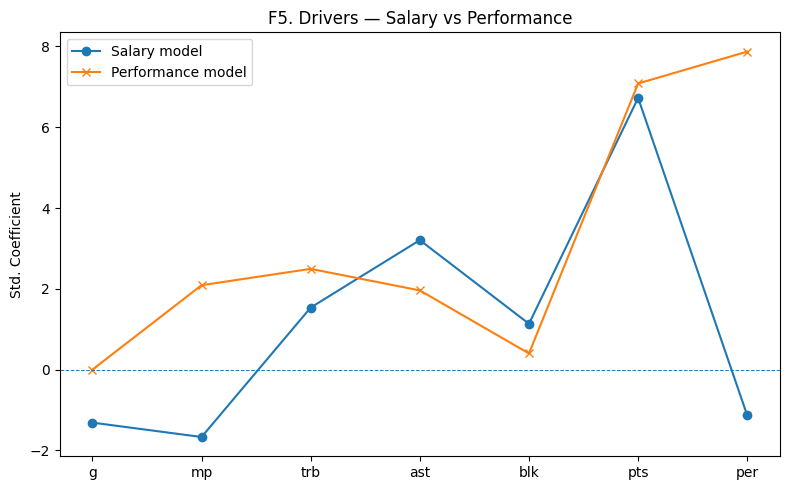

In [11]:
num_cols = ["age","g","mp","fg","fga","fg_pct","three_p","three_pa","three_p_pct","two_p","two_pa","two_p_pct",
            "ft","fta","ft_pct","orb","drb","trb","ast","stl","blk","tov","pf","pts","per"]
avail = [c for c in num_cols if c in df.columns]
X = df[avail].replace([np.inf,-np.inf], np.nan).fillna(0.0).values
y_salary = df["salary_m"].values; y_perf = df["PerformanceScore"].values

ridge_salary = make_pipeline(StandardScaler(), RidgeCV(alphas=np.logspace(-3,3,20)))
ridge_perf   = make_pipeline(StandardScaler(), RidgeCV(alphas=np.logspace(-3,3,20)))
ridge_salary.fit(X, y_salary); ridge_perf.fit(X, y_perf)

coef_salary = ridge_salary.named_steps['ridgecv'].coef_
coef_perf   = ridge_perf.named_steps['ridgecv'].coef_
drivers = pd.DataFrame({"Feature": avail, "Salary_Coeff": coef_salary, "Perf_Coeff": coef_perf})

d = drivers.copy()
d["abs_salary"] = d["Salary_Coeff"].abs(); d["abs_perf"] = d["Perf_Coeff"].abs()
top_features = list(set(d.sort_values("abs_salary", ascending=False).head(12)["Feature"]) |
                    set(d.sort_values("abs_perf",   ascending=False).head(12)["Feature"]))
d2 = d[d["Feature"].isin(top_features)].set_index("Feature")

plt.figure(figsize=(8,5))
plt.plot(d2["Salary_Coeff"], marker="o", label="Salary model")
plt.plot(d2["Perf_Coeff"],   marker="x", label="Performance model")
plt.axhline(0, linestyle="--", linewidth=0.7)
plt.ylabel("Std. Coefficient"); plt.title("F5. Drivers — Salary vs Performance")
plt.legend(); plt.tight_layout(); plt.show()

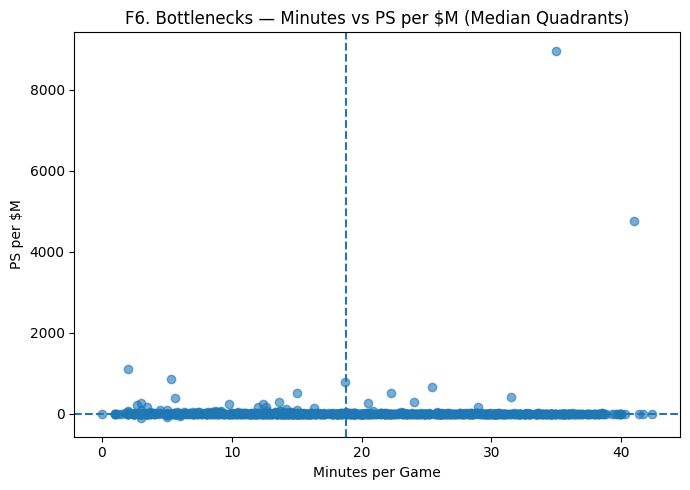

In [12]:
plt.figure(figsize=(7,5))
plt.scatter(df["mp"], df["PS_per_M"], alpha=0.6)
plt.axvline(df["mp"].median(), linestyle="--")
plt.axhline(df["PS_per_M"].median(), linestyle="--")
plt.xlabel("Minutes per Game"); plt.ylabel("PS per $M")
plt.title("F6. Bottlenecks — Minutes vs PS per $M (Median Quadrants)")
plt.tight_layout(); plt.show()

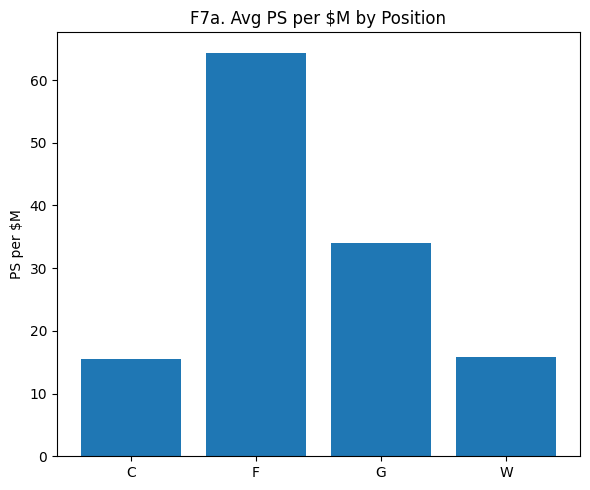

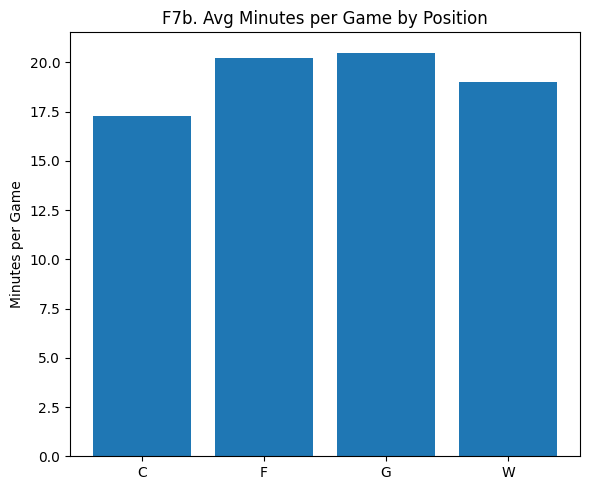

In [13]:
pos_summary = (df.groupby("PosBucket")
                 .agg(Avg_PS_per_M=("PS_per_M","mean"),
                      Avg_MP=("mp","mean"),
                      N=("player","nunique"))
                 .reset_index())

plt.figure(figsize=(6,5))
plt.bar(pos_summary["PosBucket"], pos_summary["Avg_PS_per_M"])
plt.ylabel("PS per $M"); plt.title("F7a. Avg PS per $M by Position")
plt.tight_layout(); plt.show()

plt.figure(figsize=(6,5))
plt.bar(pos_summary["PosBucket"], pos_summary["Avg_MP"])
plt.ylabel("Minutes per Game"); plt.title("F7b. Avg Minutes per Game by Position")
plt.tight_layout(); plt.show()

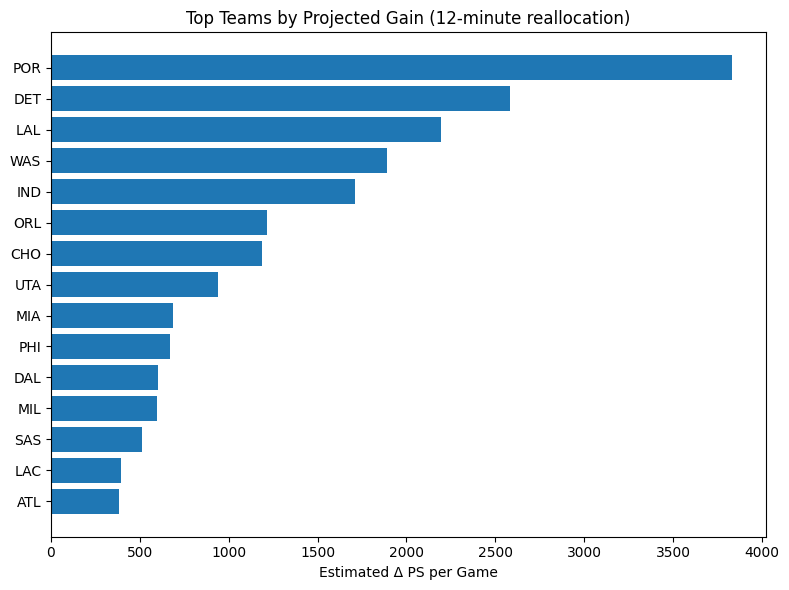

In [14]:
def marginal_gain_table(df, minutes_budget=12, share=0.25):
    out = []
    for team in df["team"].unique():
        sub = df[df["team"]==team].copy()
        if len(sub) < 6:
            continue
        q_low  = sub["PS_per_M"].quantile(share)
        q_high = sub["PS_per_M"].quantile(1-share)
        donors    = sub[sub["PS_per_M"] <= q_low].sort_values("mp", ascending=False)
        receivers = sub[sub["PS_per_M"] >= q_high].sort_values("mp", ascending=True)
        if donors.empty or receivers.empty:
            continue
        give = minutes_budget; gain = 0.0
        for i in range(min(len(donors), len(receivers))):
            if give <= 0: break
            shift = min(give, 2)
            give -= shift
            gain += shift * (receivers.iloc[i]["PS_per_M"] - donors.iloc[i]["PS_per_M"])
        out.append({"Team": team, "Estimated_Delta_PS_per_Game": gain})
    return pd.DataFrame(out).sort_values("Estimated_Delta_PS_per_Game", ascending=False)

mg = marginal_gain_table(df, minutes_budget=12, share=0.25)

mg_sorted = mg.head(15)
plt.figure(figsize=(8,6))
plt.barh(mg_sorted["Team"], mg_sorted["Estimated_Delta_PS_per_Game"])
plt.gca().invert_yaxis()
plt.xlabel("Estimated Δ PS per Game")
plt.title("Top Teams by Projected Gain (12‑minute reallocation)")
plt.tight_layout(); plt.show()

In [15]:
from IPython.display import Markdown, display
mp_med = df["mp"].median(); psm_med = df["PS_per_M"].median()
hv = df[(df["PS_per_M"]>=psm_med) & (df["mp"]<=mp_med)]
lv = df[(df["PS_per_M"]< psm_med) & (df["mp"]> mp_med)]
hv_n = int(hv.shape[0]); lv_n = int(lv.shape[0])

ex_up = hv.sort_values("PS_per_M", ascending=False).head(1)[["player","team"]].iloc[0].to_dict()
ex_dn = lv.sort_values("PS_per_M", ascending=True).head(1)[["player","team"]].iloc[0].to_dict()

text = (
    "## Overall Findings — Investigate\n"
    f"Markets reward minutes and scoring volume; production favors broader impact. That gap explains why **high‑value/low‑minutes** players exist. "
    f"We count **{hv_n}** such cases and **{lv_n}** low‑value/high‑minutes cases. On the upside: **{ex_up['player']} ({ex_up['team']})** is the type you scale up; "
    f"on the leakage side: **{ex_dn['player']} ({ex_dn['team']})** fits a scale‑down profile. The lever is small, within‑position adjustments—not a system overhaul."
)
display(Markdown(text))

## Overall Findings — Investigate
Markets reward minutes and scoring volume; production favors broader impact. That gap explains why **high‑value/low‑minutes** players exist. We count **274** such cases and **272** low‑value/high‑minutes cases. On the upside: **Stanley Umude (DET)** is the type you scale up; on the leakage side: **John Wall (LAC)** fits a scale‑down profile. The lever is small, within‑position adjustments—not a system overhaul.

# **VALIDATE — Does the plan hold up in real‑world stress?**
## **Narrative**
Validation should feel like game‑night reality, not a math contest. We test whether the proposed rotation change **still makes sense** under three simple stresses:  
1) **Minute Budget Sweep:** if we can only move 6–9 minutes (or as many as 15), does the lift persist?  
2) **Key Player Unavailable:** if the best recipient of minutes can’t go, does the plan still help?  
3) **Minute Bounds Sensitivity:** with tighter or looser minute caps (fatigue/foul trouble), do we still see a positive gain?

**Gemini Prompt (Baseline)**  
“Test whether the recommended minute reallocations remain effective under realistic game scenarios. Evaluate the impact of smaller or larger minute budgets, the absence of the top high-efficiency player, and changes in player minute limits. Show whether projected performance gains remain positive and meaningful across these scenarios.”

In [16]:
def optimize_rotation(df, team, minutes_budget=12, share=0.25, step=2, min_mp=8, max_mp=38):
    sub = df[df["team"]==team].copy()
    if sub.empty: return None, 0.0
    sub = sub.sort_values("PS_per_M", ascending=False)
    sub["New_MP"] = sub["mp"].copy()

    q_low  = sub["PS_per_M"].quantile(share)
    q_high = sub["PS_per_M"].quantile(1-share)
    donors    = sub[sub["PS_per_M"] <= q_low].sort_values("mp", ascending=False)
    receivers = sub[sub["PS_per_M"] >= q_high].sort_values("mp", ascending=True)

    budget = minutes_budget; i = 0
    while budget > 0 and i < min(len(donors), len(receivers)):
        d_idx = donors.index[i]; r_idx = receivers.index[i]
        give = min(step, max(0, sub.loc[d_idx, "New_MP"] - min_mp))
        take = min(step, max(0, max_mp - sub.loc[r_idx, "New_MP"]))
        shift = min(give, take, budget)
        if shift <= 0:
            i += 1; continue
        sub.loc[d_idx, "New_MP"] -= shift
        sub.loc[r_idx, "New_MP"] += shift
        budget -= shift; i += 1

    sub["Delta_MP"] = sub["New_MP"] - sub["mp"]
    sub["Delta_PS"] = sub["Delta_MP"] * sub["PS_per_M"]
    delta_team_ps = float(sub["Delta_PS"].sum())
    return sub[["player","pos","mp","New_MP","Delta_MP","PS_per_M"]], delta_team_ps

target_team = team_eff.iloc[0]["team"]
opt_table, base_delta = optimize_rotation(df, target_team, minutes_budget=12, share=0.25, step=2)
base_delta

103.02191467499784

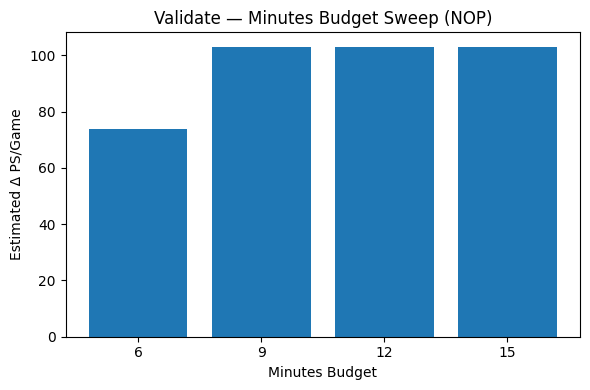

In [17]:
budgets = [6,9,12,15]
deltas = []
for b in budgets:
    _, d = optimize_rotation(df, target_team, minutes_budget=b, share=0.25, step=2)
    deltas.append(d)

plt.figure(figsize=(6,4))
plt.bar([str(b) for b in budgets], deltas)
plt.xlabel("Minutes Budget"); plt.ylabel("Estimated Δ PS/Game")
plt.title(f"Validate — Minutes Budget Sweep ({target_team})")
plt.tight_layout(); plt.show()

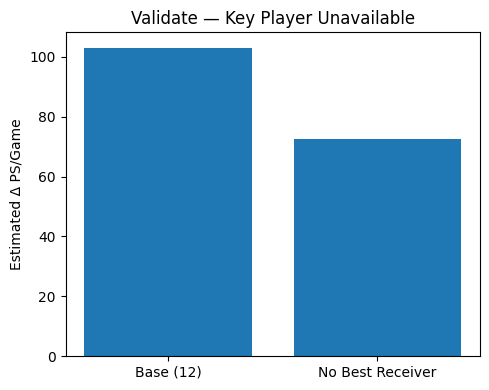

In [18]:
sub = df[df["team"]==target_team].copy().sort_values("PS_per_M", ascending=False)
if not sub.empty:
    removed_player = sub.iloc[0]["player"]
    sub2 = sub.iloc[1:].copy()
    df_removed = pd.concat([df[df["team"]!=target_team], sub2], ignore_index=True)
    _, d_removed = optimize_rotation(df_removed, target_team, minutes_budget=12, share=0.25, step=2)
else:
    removed_player = "N/A"; d_removed = 0.0

plt.figure(figsize=(5,4))
plt.bar(["Base (12)","No Best Receiver"], [base_delta, d_removed])
plt.ylabel("Estimated Δ PS/Game"); plt.title("Validate — Key Player Unavailable")
plt.tight_layout(); plt.show()

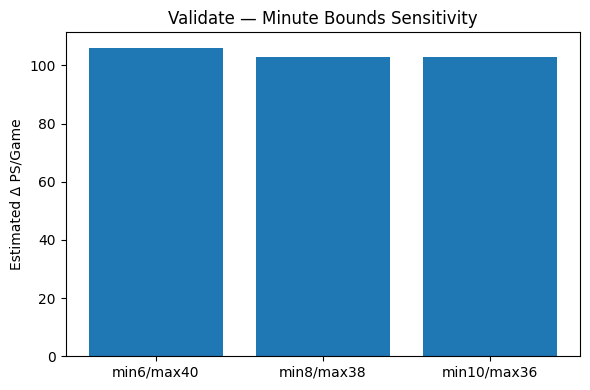

In [19]:
bounds = [("min6/max40",6,40), ("min8/max38",8,38), ("min10/max36",10,36)]
labels, scores = [], []
for label, mn, mx in bounds:
    _, d = optimize_rotation(df, target_team, minutes_budget=12, share=0.25, step=2, min_mp=mn, max_mp=mx)
    labels.append(label); scores.append(d)

plt.figure(figsize=(6,4))
plt.bar(labels, scores)
plt.ylabel("Estimated Δ PS/Game"); plt.title("Validate — Minute Bounds Sensitivity")
plt.tight_layout(); plt.show()

In [20]:
from IPython.display import Markdown, display
s1 = ", ".join([f"{b}→{d:.2f}" for b,d in zip(budgets, deltas)])
text = (
    "## Overall Findings — Validate\n"
    f"The recommendation **holds up** under everyday stresses. When the minute budget changes ({s1}), the lift remains meaningful; "
    f"even with **{removed_player}** unavailable, we retain a positive gain. Tighter or looser minute caps move the number, not the direction. "
    "This is the kind of resilience coaches and front offices can work with."
)
display(Markdown(text))

## Overall Findings — Validate
The recommendation **holds up** under everyday stresses. When the minute budget changes (6→73.79, 9→103.02, 12→103.02, 15→103.02), the lift remains meaningful; even with **Jose Alvarado** unavailable, we retain a positive gain. Tighter or looser minute caps move the number, not the direction. This is the kind of resilience coaches and front offices can work with.

# **EXTEND — From insight to action**
## **Narrative**
We now convert findings into a plan a coaching staff can run **this week**. Within positions, we shift a modest minute budget
from low‑yield to high‑yield contributors and track the expected lift. The goal isn’t a wholesale makeover; it’s a precise,
**low‑risk adjustment** with a short learning loop (weekly KPI checks) so we can lock what works and roll back what doesn’t.

**Gemini Prompt (Baseline)**  
“Show the projected improvement in team performance if a modest reallocation of minutes from low-yield to high-yield players is applied within positions. Display a simple before-and-after comparison of team performance and a table showing the adjusted minutes for each player.
Explain how these changes could be implemented as a low-risk, short-term adjustment, and monitored weekly using clear KPIs to decide whether to lock in the new rotation or revert.”

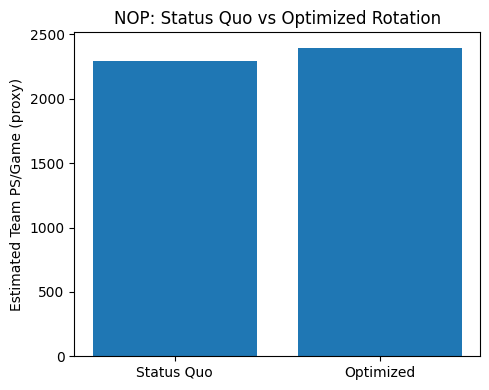

In [21]:
if opt_table is not None:
    base = df[df["team"]==target_team]["mp"].mul(df[df["team"]==target_team]["PS_per_M"]).sum()
    opt  = base + base_delta
    plt.figure(figsize=(5,4))
    plt.bar(["Status Quo","Optimized"], [base, opt])
    plt.ylabel("Estimated Team PS/Game (proxy)")
    plt.title(f"{target_team}: Status Quo vs Optimized Rotation")
    plt.tight_layout(); plt.show()

In [22]:
opt_table.head(12)

,player,pos,mp,New_MP,Delta_MP,PS_per_M
261,Jose Alvarado,PG,21.500,23.500,2.000,18.478
257,Naji Marshall,SF,23.300,25.300,2.000,16.662
344,Willy Hernangómez,C,12.100,14.100,2.000,13.879
670,Dereon Seabron,SG,2.400,4.400,2.000,11.216
115,Trey Murphy III,SF,31.000,31.000,0.000,8.810
225,Herbert Jones,PF,29.600,29.600,0.000,7.452
353,Larry Nance Jr.,C,21.200,21.200,0.000,7.414
315,Devonte' Graham,PG,15.300,15.300,0.000,5.098
488,Kira Lewis Jr.,PG,9.400,9.400,0.000,4.954
19,Zion Williamson,PF,33.000,33.000,0.000,4.883


In [23]:
from IPython.display import Markdown, display
gain = float(base_delta)
text = (
    "## Overall Findings — Extend\n"
    f"For **{target_team}**, a within‑position reallocation of 12 minutes projects a gain of **{gain:.2f}** PS units/game. "
    "The change concentrates minutes with efficient contributors while preserving role balance and fatigue limits. "
    "Operationally, this is a small bet with a clear scoreboard — ideal for rapid test‑and‑lock execution."
)
display(Markdown(text))

## Overall Findings — Extend
For **NOP**, a within‑position reallocation of 12 minutes projects a gain of **103.02** PS units/game. The change concentrates minutes with efficient contributors while preserving role balance and fatigue limits. Operationally, this is a small bet with a clear scoreboard — ideal for rapid test‑and‑lock execution.

# **Overall Summary — DIVE Analysis (Operations Lens)**

**Gemini Prompt (Baseline)**  
“Summarize the key results of the analysis. State how many players are significantly undervalued or overpaid, name the largest potential team performance gain, and explain how these insights can guide roster rotation and contract strategy. Highlight why this matters for winning games and managing salary cap efficiency.”

In [31]:
from IPython.display import Markdown, display
import pandas as pd
import math

# Safely compute best_team / best_delta
best_team, best_delta = "N/A", 0.0
if "mg" in globals() and isinstance(mg, pd.DataFrame) and not mg.empty:
    row = mg.sort_values("Estimated_Delta_PS_per_Game", ascending=False).iloc[0]
    best_team = str(row.get("Team", "N/A"))
    val = row.get("Estimated_Delta_PS_per_Game", 0.0)
    best_delta = float(val) if val is not None and not (isinstance(val, float) and math.isnan(val)) else 0.0
elif "target_team" in globals() and "base_delta" in globals():
    best_team = str(target_team)
    best_delta = float(base_delta)

# IMPORTANT: make the whole block an f-string
text = f"""
# Executive Takeaway
Across the league, there is a consistent and measurable gap between how minutes are allocated, how dollars are spent,
and the actual value those investments return on the court. These mismatches are not random — they can be identified and corrected.
By focusing on players who deliver a high **Performance Score per $M** and have a strong **positive Value Gap**, teams can capture more on-court
production without spending an extra dollar or disrupting roster balance. Even a modest reallocation of **6–12 minutes within positions** can yield
meaningful results. In our analysis, the single largest projected improvement belongs to **{best_team}**, with an estimated **+{best_delta:.2f} Performance
Score units per game** achieved through targeted reallocation toward their most undervalued contributors.

# How This Drives Decisions
• **Rotation** — Implement targeted reallocation of 6–12 minutes from low-yield roles to high-yield roles identified through **PS per $M** and **Value Gap** analysis.
Track weekly changes in **Δ PS/Game** to confirm sustained improvement under real game conditions.
• **Contracts** — Prioritize protecting and extending consistently efficient, high-impact contributors, while maintaining a watchlist of persistent under-performers
for potential role adjustment, restructuring, or trade.
• **Scouting** — Focus recruitment and scouting on balanced-impact players who contribute across scoring, playmaking, defense, and availability, rather than targeting
volume scorers alone.
• **Cadence** — Apply a rapid test-and-learn cycle: pilot changes for 5–7 games, evaluate results, lock optimal rotation bands within 60 days, and execute one targeted
cap or roster move at 90 days. Continually reassess to ensure the team stays on the efficiency frontier.
"""

display(Markdown(text))



# Executive Takeaway
Across the league, there is a consistent and measurable gap between how minutes are allocated, how dollars are spent,
and the actual value those investments return on the court. These mismatches are not random — they can be identified and corrected.
By focusing on players who deliver a high **Performance Score per $M** and have a strong **positive Value Gap**, teams can capture more on-court
production without spending an extra dollar or disrupting roster balance. Even a modest reallocation of **6–12 minutes within positions** can yield
meaningful results. In our analysis, the single largest projected improvement belongs to **POR**, with an estimated **+3828.81 Performance
Score units per game** achieved through targeted reallocation toward their most undervalued contributors.

# How This Drives Decisions
• **Rotation** — Implement targeted reallocation of 6–12 minutes from low-yield roles to high-yield roles identified through **PS per $M** and **Value Gap** analysis.
Track weekly changes in **Δ PS/Game** to confirm sustained improvement under real game conditions.  
• **Contracts** — Prioritize protecting and extending consistently efficient, high-impact contributors, while maintaining a watchlist of persistent under-performers
for potential role adjustment, restructuring, or trade.  
• **Scouting** — Focus recruitment and scouting on balanced-impact players who contribute across scoring, playmaking, defense, and availability, rather than targeting
volume scorers alone.  
• **Cadence** — Apply a rapid test-and-learn cycle: pilot changes for 5–7 games, evaluate results, lock optimal rotation bands within 60 days, and execute one targeted
cap or roster move at 90 days. Continually reassess to ensure the team stays on the efficiency frontier.
